
Random Baseline Performance:
Average final reward: 433.00
Average final energy cost: 987.40
Average accuracy: 49.28%
Average reward per timestep: 2.39

Confusion Matrix Statistics:
True Negatives: 240 (26.5%)
False Positives: 240 (26.5%)
False Negatives: 219 (24.2%)
True Positives: 206 (22.8%)
Accuracy: 49.28%
Precision: 46.19%
Recall: 48.47%
F1 Score: 47.30%

Energy usage distribution:
energy_cost
1.0     0.504972
10.0    0.495028
Name: proportion, dtype: float64


TypeError: Axes.text() missing 1 required positional argument: 's'

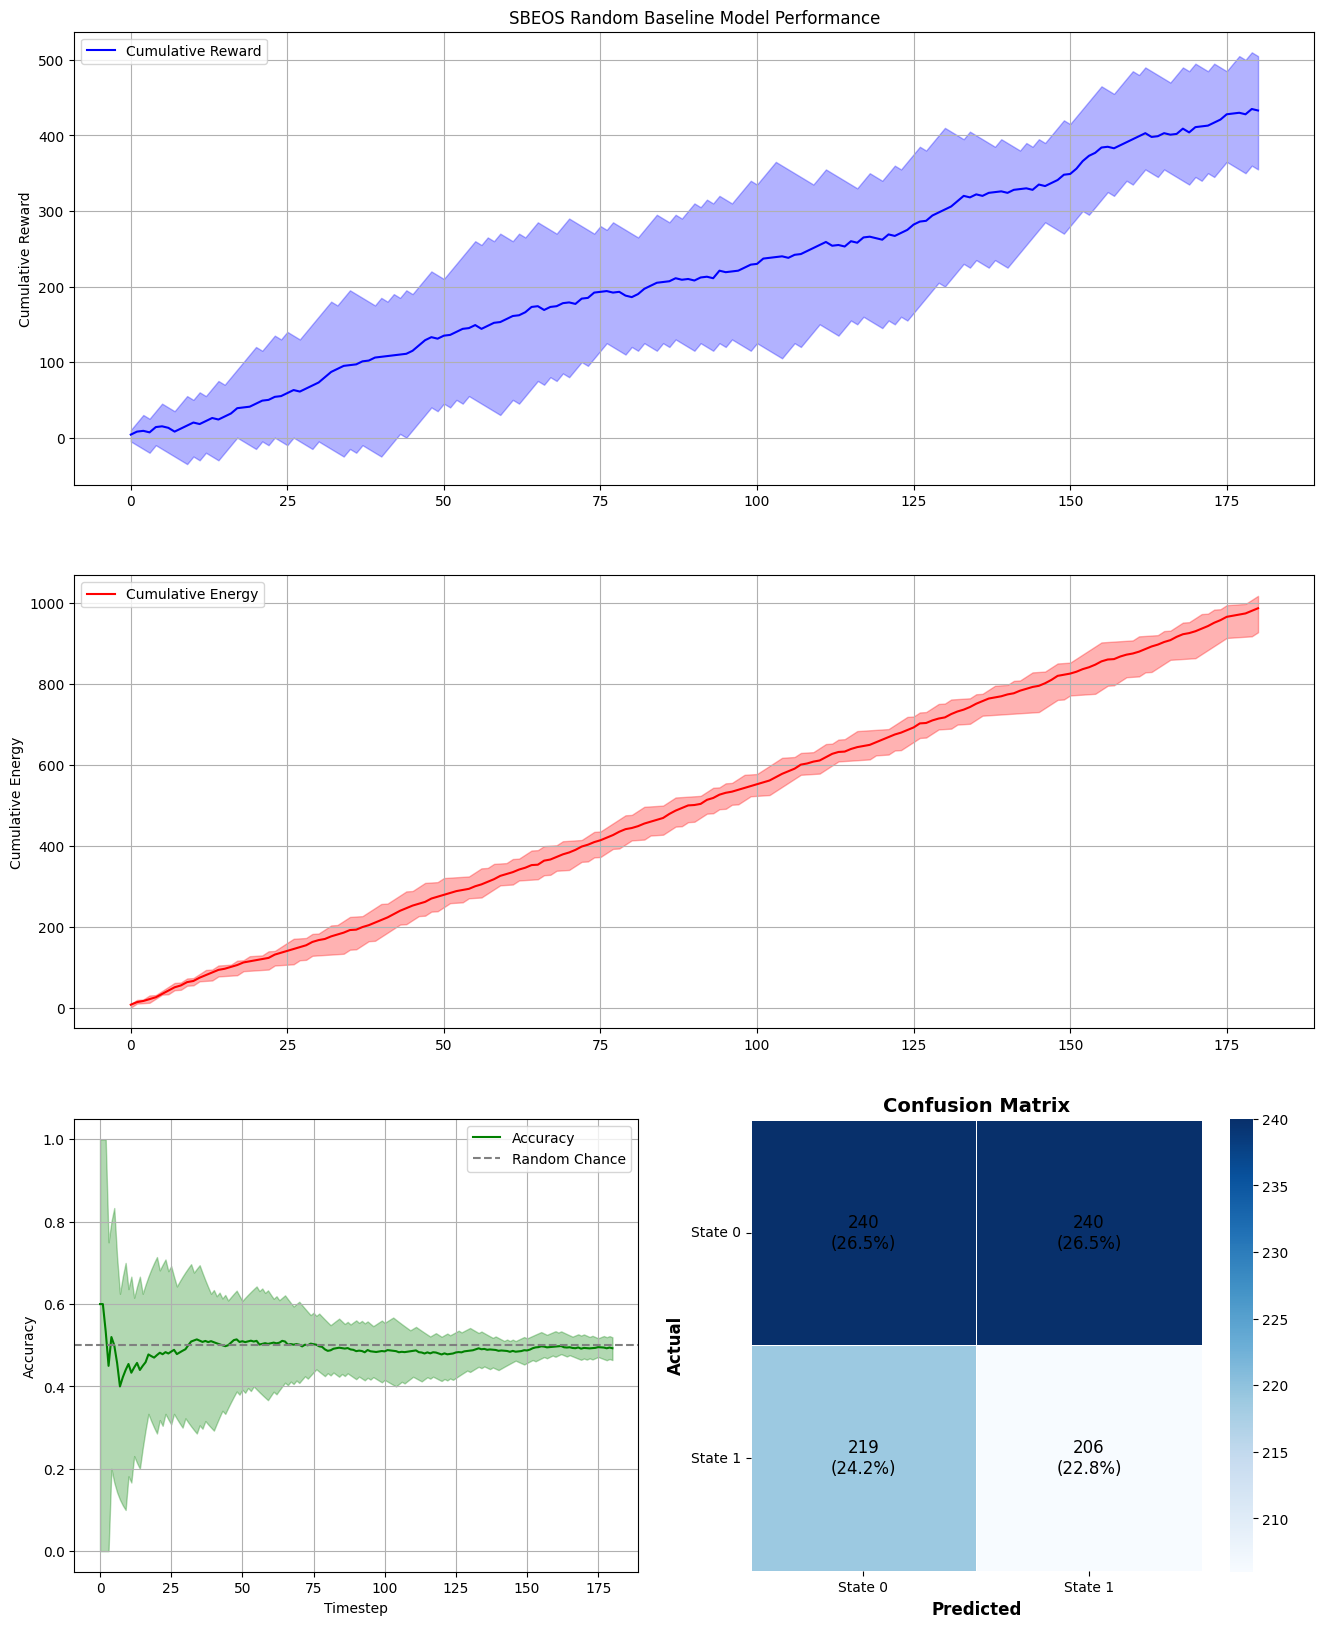

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from environments import SBEOS_Environment

# Set random seed for reproducibility
np.random.seed(42)

# Create the environment
env = SBEOS_Environment(max_timesteps=180)

def run_random_baseline(env, num_episodes=5):
    all_episode_data = []
    all_predictions = []
    all_actuals = []
    
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        total_energy = 0
        timestep = 0
        correct_predictions = 0
        
        episode_data = {
            'timestep': [],
            'reward': [],
            'cumulative_reward': [],
            'energy_cost': [],
            'cumulative_energy': [],
            'action': [],
            'actual_state': [],
            'prediction': [],
            'correct': [],
            'accuracy': []
        }
        
        episode_predictions = []
        episode_actuals = []
        
        while not done:
            # Take a random action (0 or 1 for normal energy, 2 or 3 for high energy)
            action = np.random.randint(0, 4)  # 0,1,2,3 where action%2 is the prediction
            
            # Step through the environment
            next_obs, reward, done, info = env.step(action)
            
            # Track if the prediction was correct
            prediction = action % 2
            actual_state = info['state']
            is_correct = prediction == actual_state
            
            # Store predictions and actuals for confusion matrix
            episode_predictions.append(prediction)
            episode_actuals.append(actual_state)
            
            if is_correct:
                correct_predictions += 1
            
            # Energy cost based on action
            energy_cost = info['energy_cost']
            total_energy += energy_cost
            total_reward += reward
            
            # Store data for this timestep
            episode_data['timestep'].append(timestep)
            episode_data['reward'].append(reward)
            episode_data['cumulative_reward'].append(total_reward)
            episode_data['energy_cost'].append(energy_cost)
            episode_data['cumulative_energy'].append(total_energy)
            episode_data['action'].append(action)
            episode_data['actual_state'].append(actual_state)
            episode_data['prediction'].append(prediction)
            episode_data['correct'].append(is_correct)
            episode_data['accuracy'].append(correct_predictions / (timestep + 1))
            
            obs = next_obs
            timestep += 1
        
        # Convert the episode data to a DataFrame
        episode_df = pd.DataFrame(episode_data)
        episode_df['episode'] = episode
        all_episode_data.append(episode_df)
        
        # Store all predictions and actuals for this episode
        all_predictions.extend(episode_predictions)
        all_actuals.extend(episode_actuals)
    
    # Combine all episodes into one DataFrame
    results_df = pd.concat(all_episode_data)
    
    # Add the predictions and actuals as numpy arrays
    return results_df, np.array(all_predictions), np.array(all_actuals)

# Run the random baseline model
results, all_predictions, all_actuals = run_random_baseline(env, num_episodes=5)

# Plot the results
def plot_metrics(results_df, predictions, actuals):
    # Group by timestep and calculate mean across episodes
    avg_results = results_df.groupby('timestep').mean().reset_index()
    
    # Create a figure with 3 subplots (Reward, Energy, and Accuracy)
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    # Plot 1: Cumulative Reward
    axes[0].plot(avg_results['timestep'], avg_results['cumulative_reward'], 'b-', label='Cumulative Reward')
    axes[0].fill_between(
        avg_results['timestep'],
        results_df.groupby('timestep')['cumulative_reward'].min(),
        results_df.groupby('timestep')['cumulative_reward'].max(),
        alpha=0.3, color='b'
    )
    axes[0].set_ylabel('Cumulative Reward')
    axes[0].set_title('Random Baseline Model Performance')
    axes[0].grid(True)
    axes[0].legend()
    
    # Plot 2: Cumulative Energy Cost
    axes[1].plot(avg_results['timestep'], avg_results['cumulative_energy'], 'r-', label='Cumulative Energy')
    axes[1].fill_between(
        avg_results['timestep'],
        results_df.groupby('timestep')['cumulative_energy'].min(),
        results_df.groupby('timestep')['cumulative_energy'].max(),
        alpha=0.3, color='r'
    )
    axes[1].set_ylabel('Cumulative Energy Cost')
    axes[1].grid(True)
    axes[1].legend()
    
    # Plot 3: Accuracy over time
    axes[2].plot(avg_results['timestep'], avg_results['accuracy'], 'g-', label='Accuracy')
    axes[2].fill_between(
        avg_results['timestep'],
        results_df.groupby('timestep')['accuracy'].min(),
        results_df.groupby('timestep')['accuracy'].max(),
        alpha=0.3, color='g'
    )
    axes[2].set_ylabel('Accuracy')
    axes[2].set_xlabel('Timestep')
    axes[2].grid(True)
    axes[2].axhline(y=0.5, color='gray', linestyle='--', label='Random Chance')
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig('performance_metrics.png')
    plt.close()
    
    # Create an enhanced confusion matrix
    cm = confusion_matrix(actuals, predictions)
    
    # Calculate percentages for annotations
    cm_sum = np.sum(cm)
    cm_percentages = cm / cm_sum * 100
    
    # Create labels for the confusion matrix
    labels = ["0", "1"]
    
    # Create the figure for confusion matrix
    plt.figure(figsize=(10, 8))
    
    # Create a custom colormap that goes from white to dark blue
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    # Plot the heatmap with both count and percentage annotations
    ax = sns.heatmap(cm, annot=False, cmap=cmap, cbar=True, 
                     square=True, fmt='d', linewidths=.5)
    
    # Add counts and percentages as annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = f"{cm[i, j]}\n({cm_percentages[i, j]:.1f}%)"
            ax.text(j + 0.5, i + 0.5, text, ha='center', va='center',
                   fontsize=14, color='black' if cm_percentages[i, j] < 50 else 'white')
    
    # Set labels and title
    plt.xlabel('Predicted', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=14, fontweight='bold')
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    
    # Set x and y tick labels with proper descriptions
    tick_labels = ["State 0", "State 1"]
    plt.xticks([0.5, 1.5], tick_labels, fontsize=12)
    plt.yticks([0.5, 1.5], tick_labels, fontsize=12, rotation=0)
    
    # Add a color bar legend
    cbar = ax.collections[0].colorbar
    cbar.set_label('Count', fontsize=12)
    
    # Add descriptive text for each quadrant
    plt.text(0.25, -0.1, "True Negative", ha='center', transform=ax.transAxes, fontsize=12)
    plt.text(0.75, -0.1, "False Positive", ha='center', transform=ax.transAxes, fontsize=12)
    plt.text(0.25, 1.1, "False Negative", ha='center', transform=ax.transAxes, fontsize=12)
    plt.text(0.75, 1.1, "True Positive", ha='center', transform=ax.transAxes, fontsize=12)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.close()
    
    # Print summary statistics
    print("\nRandom Baseline Performance:")
    print(f"Average final reward: {avg_results['cumulative_reward'].iloc[-1]:.2f}")
    print(f"Average final energy cost: {avg_results['cumulative_energy'].iloc[-1]:.2f}")
    print(f"Average accuracy: {avg_results['accuracy'].iloc[-1]:.2%}")
    print(f"Average reward per timestep: {avg_results['reward'].mean():.2f}")
    
    # Add confusion matrix statistics
    tn, fp, fn, tp = cm.ravel()
    total = np.sum(cm)
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print("\nConfusion Matrix Statistics:")
    print(f"True Negatives: {tn} ({tn/total:.1%})")
    print(f"False Positives: {fp} ({fp/total:.1%})")
    print(f"False Negatives: {fn} ({fn/total:.1%})")
    print(f"True Positives: {tp} ({tp/total:.1%})")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")
    
    # Energy usage distribution
    energy_distribution = results_df['energy_cost'].value_counts(normalize=True)
    print("\nEnergy usage distribution:")
    print(energy_distribution)

# Execute the plotting function
plot_metrics(results, all_predictions, all_actuals)

# Create a combined visualization with all the metrics in one figure
def create_combined_visualization(results_df, predictions, actuals):
    # Create a figure with 4 subplots
    fig = plt.figure(figsize=(16, 20))
    
    # Plot 1: Cumulative Reward
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    avg_results = results_df.groupby('timestep').mean().reset_index()
    
    ax1.plot(avg_results['timestep'], avg_results['cumulative_reward'], 'b-', label='Cumulative Reward')
    ax1.fill_between(
        avg_results['timestep'],
        results_df.groupby('timestep')['cumulative_reward'].min(),
        results_df.groupby('timestep')['cumulative_reward'].max(),
        alpha=0.3, color='b'
    )
    ax1.set_ylabel('Cumulative Reward')
    ax1.set_title('SBEOS Random Baseline Model Performance')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Cumulative Energy
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax2.plot(avg_results['timestep'], avg_results['cumulative_energy'], 'r-', label='Cumulative Energy')
    ax2.fill_between(
        avg_results['timestep'],
        results_df.groupby('timestep')['cumulative_energy'].min(),
        results_df.groupby('timestep')['cumulative_energy'].max(),
        alpha=0.3, color='r'
    )
    ax2.set_ylabel('Cumulative Energy')
    ax2.grid(True)
    ax2.legend()
    
    # Plot 3: Accuracy
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax3.plot(avg_results['timestep'], avg_results['accuracy'], 'g-', label='Accuracy')
    ax3.fill_between(
        avg_results['timestep'],
        results_df.groupby('timestep')['accuracy'].min(),
        results_df.groupby('timestep')['accuracy'].max(),
        alpha=0.3, color='g'
    )
    ax3.set_ylabel('Accuracy')
    ax3.set_xlabel('Timestep')
    ax3.grid(True)
    ax3.axhline(y=0.5, color='gray', linestyle='--', label='Random Chance')
    ax3.legend()
    
    # Plot 4: Confusion Matrix
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    cm = confusion_matrix(actuals, predictions)
    
    # Calculate percentages for annotations
    cm_sum = np.sum(cm)
    cm_percentages = cm / cm_sum * 100
    
    # Create a custom colormap
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    # Plot the heatmap
    sns.heatmap(cm, annot=False, cmap=cmap, cbar=True, 
                square=True, fmt='d', linewidths=.5, ax=ax4)
    
    # Add counts and percentages as annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = f"{cm[i, j]}\n({cm_percentages[i, j]:.1f}%)"
            ax4.text(j + 0.5, i + 0.5, text, ha='center', va='center',
                   fontsize=12, color='black' if cm_percentages[i, j] < 50 else 'white')
    
    # Set labels and title
    ax4.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Actual', fontsize=12, fontweight='bold')
    ax4.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    
    # Set tick labels
    tick_labels = ["State 0", "State 1"]
    ax4.set_xticklabels(tick_labels, fontsize=10)
    ax4.set_yticklabels(tick_labels, fontsize=10, rotation=0)
    
    # Add quadrant annotations
    quadrant_labels = [["True Negative", "False Positive"], 
                      ["False Negative", "True Positive"]]
                      
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    
    for i in range(2):
        for j in range(2):
            ax4.text(j + 0.5, i + 0.82, quadrant_labels[i][j], 
                    ha='center', va='center', size=8,
                    bbox=bbox_props)
    
    plt.tight_layout()
    # plt.savefig('combined_visualization.png', dpi=300)
    plt.show()
    plt.close()

# Create the combined visualization
create_combined_visualization(results, all_predictions, all_actuals)

print("Visualizations have been generated!")